In [252]:
from rayoptics.environment import *
isdark = False

opm = OpticalModel()
sm = opm['seq_model']
osp = opm['optical_spec']
pm = opm['parax_model']
em = opm['ele_model']
pt = opm['part_tree']
ar = opm['analysis_results']


beta = 5
r_max_sensor = 3.1

osp['pupil'] = PupilSpec(osp, key=['object', 'NA'], value=0.06)
# osp['pupil'] = PupilSpec(osp, key=['object', 'NA'], value=0.02)
osp['fov'] = FieldSpec(osp, key=['object', 'height'], value=0.6, flds=[0., 0.1 / beta, 1. / beta, r_max_sensor / beta], is_relative=True)
# osp['wvls'] = WvlSpec([(530.0, 1.0), (550.0, 1.0), (570.0, 1.0)], ref_wl=1)
# osp['wvls'] = WvlSpec([(550.0, 1.0), (549.0, 1.0), (551.0, 1.0)], ref_wl=0)
osp['wvls'] = WvlSpec([(550.0, 1.0)], ref_wl=0)


opm.radius_mode = True



# sm.gaps[0].thi=50.2
# sm.add_surface([+33.3, 9.0, 'N-BAF10', 'Schott'])
# sm.add_surface([-22.3, 2.5, 'N-SF10', 'Schott'])
# sm.add_surface([-300, 43.4])

sm.gaps[0].thi=28.17 #- 12 - 2.0
# opt 28.17
sm.add_surface([+20.89, 12.0, 'N-BAF10', 'Schott'])
sm.add_surface([-16.73, 2.00, 'N-SF6HT', 'Schott'])
sm.add_surface([-79.8, 22.9])
sm.set_stop()

# sm.add_surface([np.inf, 50.2])
# sm.add_surface([+33.3, 9.0, 'N-BAF10', 'Schott'])
# sm.add_surface([-22.3, 2.5, 'N-SF10', 'Schott'])
# sm.add_surface([-300., 43.4])


sm.add_surface([np.inf, 150.0])
sm.add_surface([+91.62, 5.7, 'N-BK7', 'Schott'])
sm.add_surface([-66.68, 2.2, 'SF5', 'Schott'])
# sm.add_surface([-197.7, 146.1])
# sm.add_surface([-197.7, 126.1])
# sm.add_surface([-197.7, 155.19]) # max NA
sm.add_surface([-197.7, 172.07]) # half NA
# 155.19

print(pt.root_node)

opm.update_model()
sm.list_model()

pt.list_model()


Node('/root', id=<rayoptics.elem.parttree.PartTree object at 0x7f9e4badda60>, tag='#group#root')
              r            t        medium     mode   zdr      sd
  Obj:     0.000000      28.1700       air             1     0.23064
    1:    20.890000      12.0000   N-BAF10             1      1.7593
    2:   -16.730000      2.00000   N-SF6HT             1      1.7383
 Stop:   -79.800000      22.9000       air             1      1.7521
    4:     0.000000      150.000       air             1      1.9681
    5:    91.620000      5.70000     N-BK7             1      3.3829
    6:   -66.680000      2.20000       SF5             1      3.3473
    7:  -197.700000      172.070       air             1      3.3449
  Img:     0.000000      0.00000                       1      1.2201
root
├── Object
├── CE47
├── S24
├── CE48
└── Image


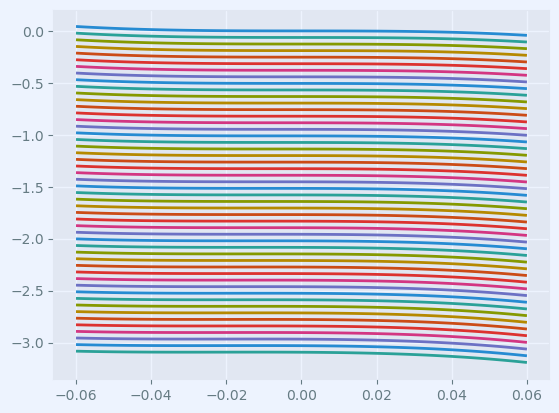

In [253]:
n_rays = 50
NA = 0.06
x_range = np.linspace(0., 0.62)
k_range = np.linspace(-NA, NA, n_rays)
fig, ax = plt.subplots()
for x0 in np.linspace(0., 0.62):
    target = np.zeros((n_rays, 3))
    for i, k in enumerate(k_range):
        data = trace(sm, np.array([x0, 0., 0.]), np.array([k, 0., 1]), 550)
        target[i] = data[0][-1][0]
    ax.plot(k_range, target[:,0])
plt.show()

In [254]:
def merit(sm):
    NA = 0.12
    data = trace(sm, np.array([0., 0., 0.]), np.array([NA, 0., 1]), 550)
    return data[0][-1][0][0]
merit(sm)


-0.3486655527919039

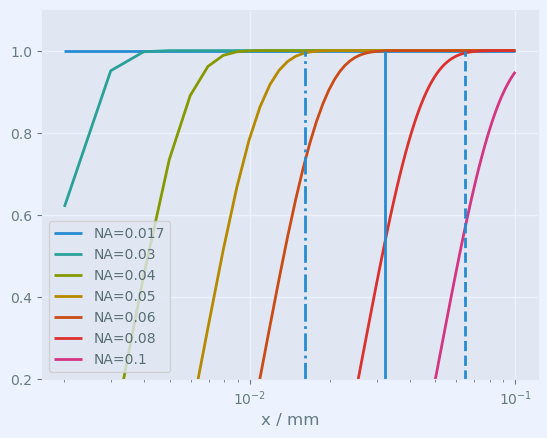

In [265]:
def calc_contrast(pitch, x0=0, na=0.06):
    n_rays = 13
    angles = np.linspace(-na, na, n_rays)
    x_bright = x0 + pitch

    data = np.zeros((n_rays, 2))
    for i, angle in enumerate(angles):
        ray = trace(sm, np.array([x0, 0., 0.]), np.array([angle, 0., 1]), 550)
        data[i,0] = ray[0][-1][0][0]
        ray = trace(sm, np.array([x_bright, 0., 0.]), np.array([angle, 0., 1]), 550)
        data[i,1] = ray[0][-1][0][0]

    center = np.mean(data)
    center_int = 0
    for i in range(2):
        center_int += np.exp(-np.square((center - np.mean(data[:,i])) / np.std(data[:,i])) / 2)

    return 1 - center_int

def plot_mtf(ax, na):
    pitches = np.linspace(2, 100, 100) * 1e-3
    # pitches = 1000 / np.linspace(1, 25)
    contrast = np.zeros_like(pitches)
    for i, pitch in enumerate(pitches):
        contrast[i] = calc_contrast(pitch, na=na)

    ax.semilogx(pitches, contrast, label=f"NA={na}")

fig, ax = plt.subplots()
nas = [0.017, 0.03, 0.04, 0.05, 0.06, 0.08, 0.1]
for i, na in enumerate(nas):
    plot_mtf(ax, na)
i = 0
na = nas[i]
ax.vlines([550e-6 / na / 2], 0, 1, color=f"C{i}", ls="-.")
ax.vlines([550e-6 / na], 0, 1, color=f"C{i}", ls="-")
ax.vlines([2 * 550e-6 / na], 0, 1, color=f"C{i}", ls="--")
ax.legend()
ax.set_xlabel("x / mm")
ax.set_ylim(0.2, 1.1)
plt.show()


In [256]:
sm.gaps

[Gap(t=28.17, medium=<opticalglass.opticalmedium.Air object at 0x7f9e586916d0>),
 Gap(t=12.0, medium=SchottGlass('N-BAF10')),
 Gap(t=2.0, medium=SchottGlass('N-SF6HT')),
 Gap(t=22.9, medium=<opticalglass.opticalmedium.Air object at 0x7f9e4bcafef0>),
 Gap(t=150.0, medium=<opticalglass.opticalmedium.Air object at 0x7f9e4bcac2f0>),
 Gap(t=5.7, medium=SchottGlass('N-BK7')),
 Gap(t=2.2, medium=SchottGlass('SF5')),
 Gap(t=172.07, medium=<opticalglass.opticalmedium.Air object at 0x7f9e51215e50>)]

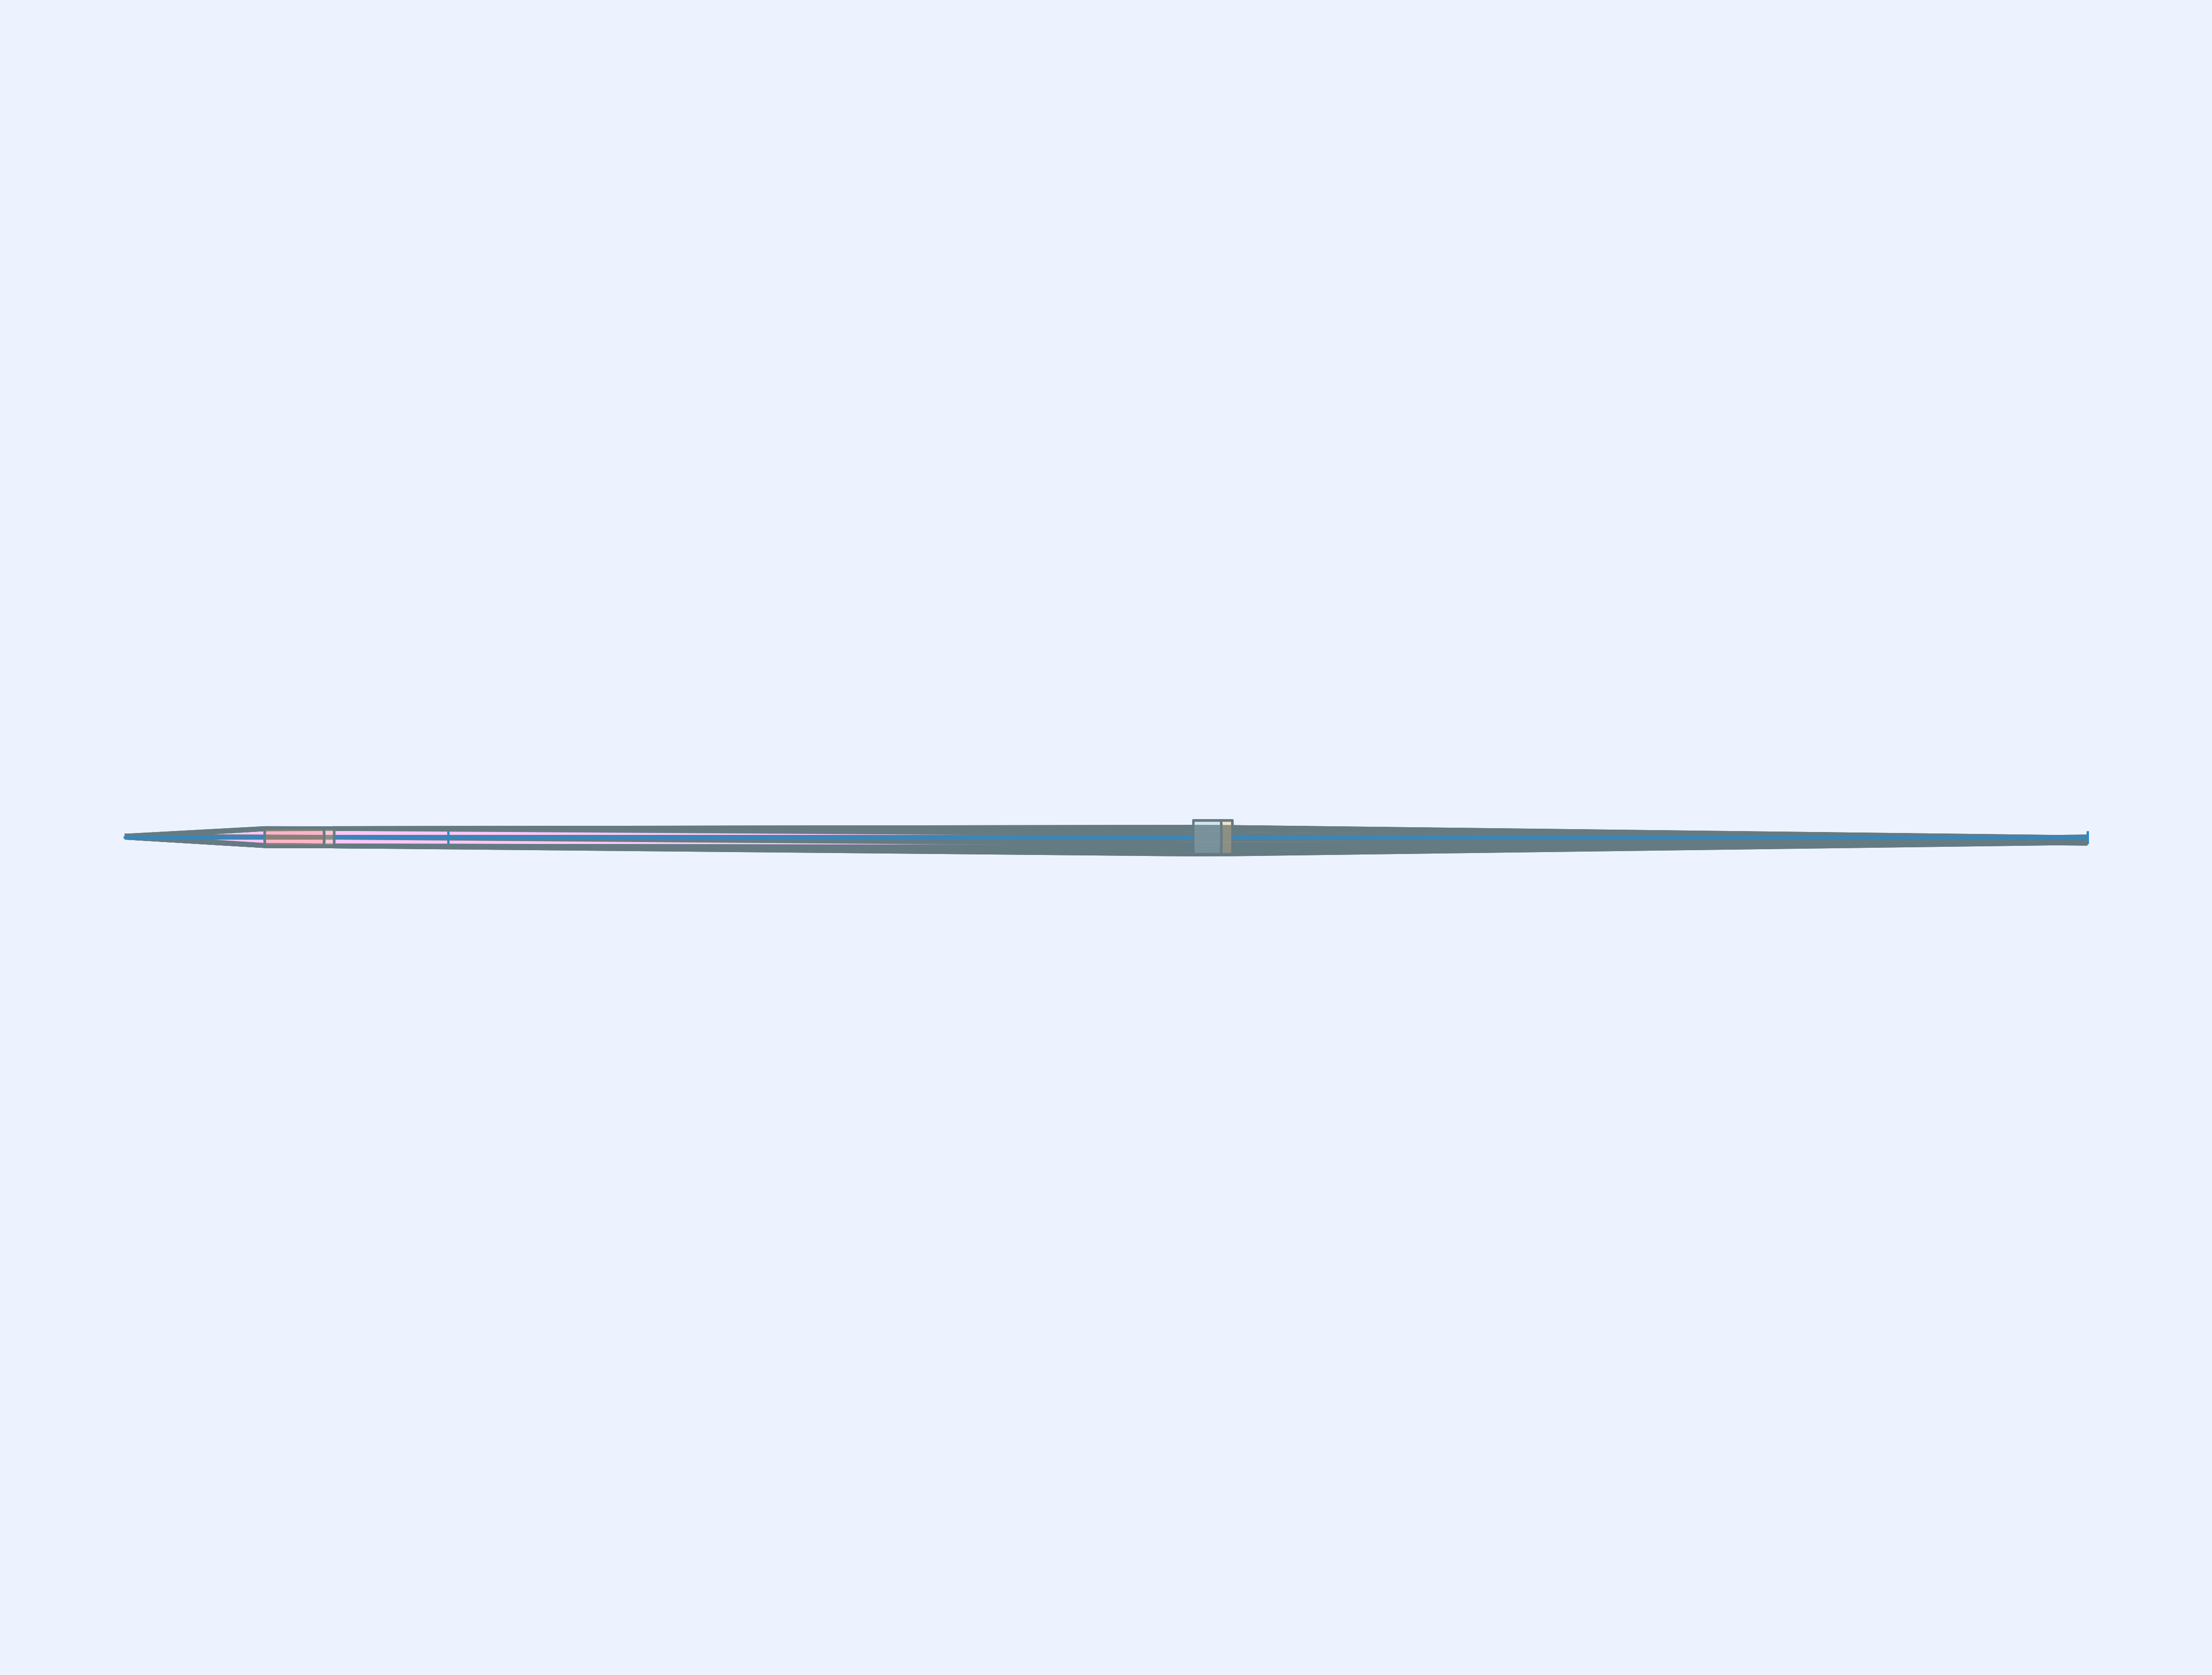

In [257]:
layout_plt = plt.figure(FigureClass=InteractiveLayout, opt_model=opm, is_dark=isdark, dpi=700).plot()

In [258]:
em.list_model()

0: Object (DummyInterface): Surface(lbl='Obj', profile=Spherical(c=0.0), interact_mode='dummy')
1: CE47 (CementedElement): CementedElement: [1, 2, 3]
2: S24 (SurfaceInterface): Surface: Spherical(c=0.0), sd=1.9681
3: CE48 (CementedElement): CementedElement: [5, 6, 7]
4: Image (DummyInterface): Surface(lbl='Img', profile=Spherical(c=0.0), interact_mode='dummy')


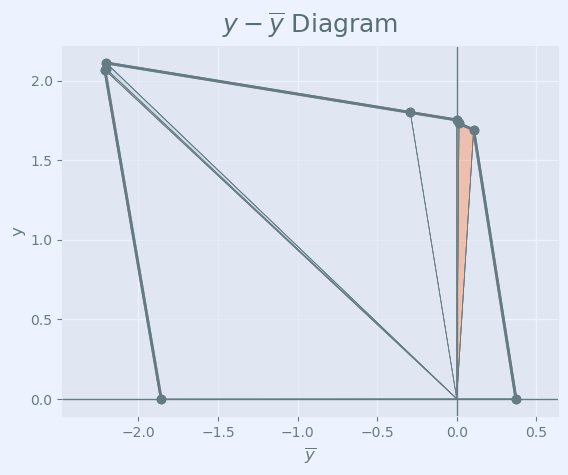

In [259]:
yybar_plt = plt.figure(FigureClass=InteractiveDiagram, opt_model=opm, dgm_type='ht',
                       do_draw_axes=True, do_draw_frame=True, is_dark=isdark).plot()

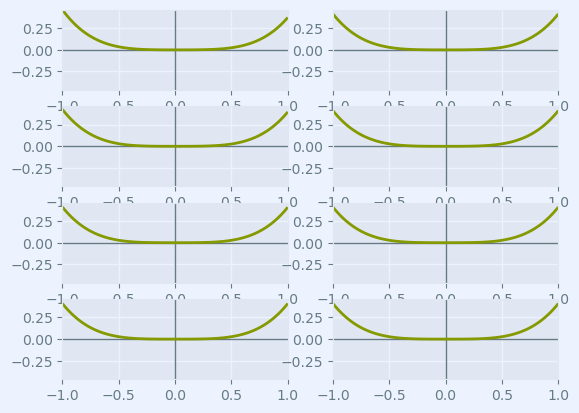

In [260]:
wav_plt = plt.figure(FigureClass=RayFanFigure, opt_model=opm, data_type='OPD', scale_type=Fit.All_Same, is_dark=isdark).plot()


In [261]:
pm.first_order_data()

efl               -2212
f                 -2212
f'                -2212
ffl              -471.3
pp1               -2684
bfl           1.122e+04
ppk           1.343e+04
pp sep        1.631e+04
f/#                41.6
m                -4.992
red             -0.2003
obj_dist          28.17
obj_ang         -0.5404
enp_dist          11.27
enp_radius        2.366
na obj             0.06
n obj                 1
img_dist            172
img_ht           -1.857
exp_dist           1075
exp_radius        10.85
na img         -0.01202
n img                 1
optical invariant     -0.02232


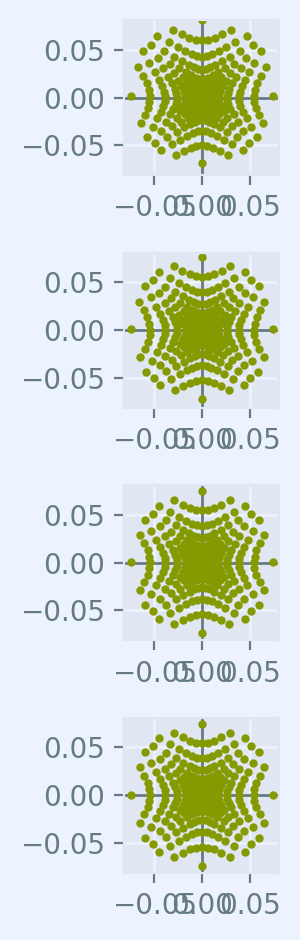

In [262]:
spot_plt = plt.figure(FigureClass=SpotDiagramFigure, opt_model=opm,
                      scale_type=Fit.All_Same, dpi=200, is_dark=isdark).plot()

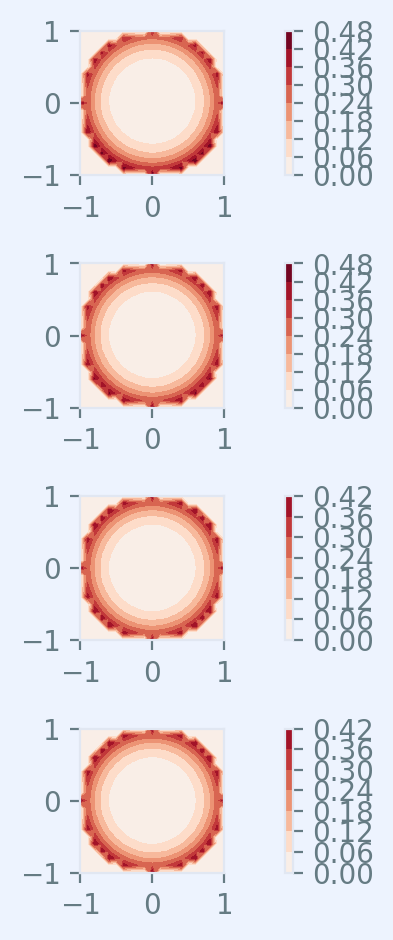

In [263]:
spot_plt = plt.figure(FigureClass=WavefrontFigure, opt_model=opm,
                      scale_type=Fit.All_Same, dpi=200, is_dark=isdark).plot()